In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Drill
print('4:', 1 * np.log2(6/2), 1 * np.log2(6/3), 0, 1 * np.log2(6/3), 1 * np.log2(6/2), 0, 0, 0, 0)
print('5:', 0, 0, 0, 0, 0, 1 * np.log2(6/4), 1 * np.log2(6/3), 1* np.log2(6/2), 1*np.log2(6/3))
print('6:', 0, 0, 0, 0, 0, 0, 1*np.log2(6/3), 0, 2*np.log2(6/3))

4: 1.58496250072 1.0 0 1.0 1.58496250072 0 0 0 0
5: 0 0 0 0 0 0.584962500721 1.0 1.58496250072 1.0
6: 0 0 0 0 0 0 1.0 0 2.0


In [3]:
import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split
gutenberg.paras
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-persuasion.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/joshuarkarnad/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
['[ Persuasion by Jane Austen 1818 ]', 'Chapter 1', 'Sir Walter Elliot , of Kellynch Hall , in Somersetshire , was a man who , for his own amusement , never took up any book but the Baronetage ; there he found occupation for an idle hour , and consolation in a distressed one ; there his faculties were roused into admiration and respect , by contemplating the limited remnant of the earliest patents ; there any unwelcome sensations , arising from domestic affairs changed naturally into pity and contempt as he turned over the almost endless creations of the last century ; and there , if every other leaf were powerless , he could read his own history with an interest which never failed .', '" ELLIOT OF KELLYNCH HALL .']


In [4]:
emma_paras

['[ Persuasion by Jane Austen 1818 ]',
 'Chapter 1',
 'Sir Walter Elliot , of Kellynch Hall , in Somersetshire , was a man who , for his own amusement , never took up any book but the Baronetage ; there he found occupation for an idle hour , and consolation in a distressed one ; there his faculties were roused into admiration and respect , by contemplating the limited remnant of the earliest patents ; there any unwelcome sensations , arising from domestic affairs changed naturally into pity and contempt as he turned over the almost endless creations of the last century ; and there , if every other leaf were powerless , he could read his own history with an interest which never failed .',
 '" ELLIOT OF KELLYNCH HALL .',
 '" Walter Elliot , born March 1 , 1760 , married , July 15 , 1784 , Elizabeth , daughter of James Stevenson , Esq .',
 'Precisely such had the paragraph originally stood from the printer \' s hands ; but Sir Walter had improved it by adding , for the information of hims

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1232
Original sentence: " My expressions startle you .
Tf_idf vector: {'expressions': 1.0}


In [6]:
print('Original sentence:', X_train[6])
print('Tf_idf vector:', tfidf_bypara[6])

Original sentence: Her recent good offices by Anne had been enough in themselves , and their marriage , instead of depriving her of one friend , secured her two .
Tf_idf vector: {'offices': 0.52943946135907272, 'instead': 0.5071771228942582, 'anne': 0.18937407732603223, 'marriage': 0.45353778065772088, 'friend': 0.33932444019336311, 'good': 0.32521544767886001}


In [7]:
print('Original sentence:', X_train[7])
print('Tf_idf vector:', tfidf_bypara[7])

Original sentence: " I think you are very likely to suffer the most of the two ; your feelings are less reconciled to the change than mine .
Tf_idf vector: {'suffer': 0.53780180839761338, 'likely': 0.44765195233612037, 'think': 0.35306545173183851, 'change': 0.46261288284037377, 'feelings': 0.41438032274400755}


In [8]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 59.13128404
Component 0:
" Oh !    0.999274
" Oh !    0.999274
" Oh !    0.999274
" Oh !    0.999274
" Oh !    0.999274
" Oh !    0.999274
" Oh !    0.999274
" Oh !    0.999274
" Oh !    0.999274
" Oh !    0.999274
Name: 0, dtype: float64
Component 1:
Chapter 12    0.999844
Chapter 7     0.999844
Chapter 8     0.999844
Chapter 4     0.999844
Chapter 22    0.999844
Chapter 2     0.999844
Chapter 17    0.999844
Chapter 20    0.999844
Chapter 5     0.999844
Chapter 13    0.999844
Name: 1, dtype: float64
Component 2:
" This accounts for something which Mr Elliot said last night ," cried Anne .                                                             0.503968
From this time Captain Wentworth and Anne Elliot were repeatedly in the same circle .                                                     0.503790
" Captain Wentworth is not very gallant by you , Anne , though he was so attentive to me .                                                0.49

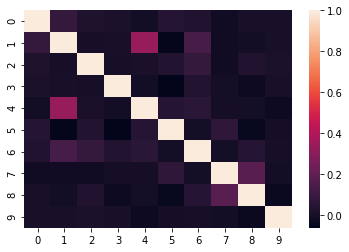

Key:
0 When the evening was over , Anne could not but be amused at the idea of her coming to Lyme to preach patience and resignation to a young man whom she had never seen before ; nor could she help fearing , on more serious reflection , that , like many other great moralists and preachers , she had been eloquent on a point in which her own conduct would ill bear examination .
1 The nights were too dark for the ladies to meet again till the morrow , but Captain Harville had promised them a visit in the evening ; and he came , bringing his friend also , which was more than had been expected , it having been agreed that Captain Benwick had all the appearance of being oppressed by the presence of so many strangers .
2 " No ," cried Anne , quickly , " it cannot be Mr Elliot , I assure you .
3 She paused a moment to recover from the emotion of hearing herself so spoken of .
4 Captain Harville smiled , as much as to say , " Do you claim that for your sex ?"
5 " My expressions startle you .


In [9]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

In [10]:
testlsa = lsa.transform(X_test_tfidf)

In [11]:
paras_by_component=pd.DataFrame(testlsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   0.999274
" Oh !"                                                                                                                                                                                                                                                  

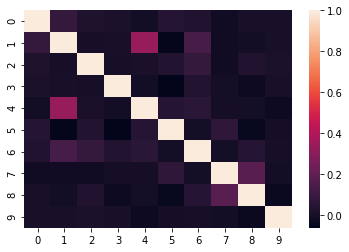

Key:
0 When the evening was over , Anne could not but be amused at the idea of her coming to Lyme to preach patience and resignation to a young man whom she had never seen before ; nor could she help fearing , on more serious reflection , that , like many other great moralists and preachers , she had been eloquent on a point in which her own conduct would ill bear examination .
1 The nights were too dark for the ladies to meet again till the morrow , but Captain Harville had promised them a visit in the evening ; and he came , bringing his friend also , which was more than had been expected , it having been agreed that Captain Benwick had all the appearance of being oppressed by the presence of so many strangers .
2 " No ," cried Anne , quickly , " it cannot be Mr Elliot , I assure you .
3 She paused a moment to recover from the emotion of hearing herself so spoken of .
4 Captain Harville smiled , as much as to say , " Do you claim that for your sex ?"
5 " My expressions startle you .


In [12]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])

<h1> Drill 0: Test Set

In [13]:
X_test_lsa = lsa.transform(X_test_tfidf)
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test) 
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
" Oh !                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   0.999288
" Oh !"                                                                                                                                                                                                                                                  

Component 0: Identifies 'Oh' <br>
Component 1: Identifies Chapeters <br>
Component 2: Identifies Anne and Mr Elliot (more about Anne) <br>
Component 3: Identifies Anne and Mr Elliot (more dialogue) <br>
Component 4: Identifies dialogue involing 'Yes'

In [18]:
#Tweaks Go Here

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.1, # drop words that occur in more than 70% the paragraphs
                             min_df=2, # only use words that appear at 10 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1230
Original sentence: " My expressions startle you .
Tf_idf vector: {'expressions': 1.0}


In [19]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
#This is just condensing the steps of running SVD and then normalizing the data
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 58.6439342477
Component 0:
" Oh !    0.99928
" Oh !    0.99928
" Oh !    0.99928
" Oh !    0.99928
" Oh !    0.99928
" Oh !    0.99928
" Oh !    0.99928
" Oh !    0.99928
" Oh !    0.99928
" Oh !    0.99928
Name: 0, dtype: float64
Component 1:
Chapter 4     0.999941
Chapter 8     0.999941
Chapter 12    0.999941
Chapter 2     0.999941
Chapter 5     0.999941
Chapter 7     0.999941
Chapter 13    0.999941
Chapter 20    0.999941
Chapter 10    0.999941
Chapter 3     0.999941
Name: 1, dtype: float64
Component 2:
" Pray ," said Mrs Smith , " is Mr Elliot aware of your acquaintance with me ?                                                                                                                                       0.563708
" Mr Elliot !"                                                                                                                                                                                                       0.528606


In [20]:
#Tweaks Go Here

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.2, # drop words that occur in more than 70% the paragraphs
                             min_df=5, # only use words that appear at 10 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 414
Original sentence: " My expressions startle you .
Tf_idf vector: {}


In [21]:
print('Original sentence:', X_train[4])
print('Tf_idf vector:', tfidf_bypara[4])

Original sentence: Captain Harville smiled , as much as to say , " Do you claim that for your sex ?"
Tf_idf vector: {'smiled': 0.52958239721203559, 'harville': 0.428412842064262, 'captain': 0.28306745311568243, 'say': 0.40101143525259431, 'claim': 0.54320122155682848}


In [22]:
#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
#This is just condensing the steps of running SVD and then normalizing the data
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 73.9065291819
Component 0:
" Oh !     0.999166
" Oh !     0.999166
" Oh !     0.999166
" Oh !     0.999166
" Oh !     0.999166
" Oh !"    0.999166
" Oh !     0.999166
" Oh !     0.999166
" Oh !     0.999166
" Oh !     0.999166
Name: 0, dtype: float64
Component 1:
From this time Captain Wentworth and Anne Elliot were repeatedly in the same circle .                                                                                                                                                                                                                                                         0.532233
" Pray ," said Mrs Smith , " is Mr Elliot aware of your acquaintance with me ?                                                                                                                                                                                                                                                                0.489304
But M